In [2]:
ALL_SOURCE_BOOKS = ['BR','PH','MM','HotDQ','RoT','DMG','PotA','OotA','SCAG','CoS','SKT','VGtM','TftYP','ToA','XGtE','MToF','WDH','WDotMM','GGtR','GoS','BGDiA','ERftLW','EGtW','MOoT','IDRotF','TCoE','CM']
ALL_RULES_BOOKS = ['BR','PH','MM','DMG','SCAG','VGtM','XGtE','MToF','GGtR','ERftLW','EGtW','MOoT','TCoE']
ALL_ADVENTURE_BOOKS = ['HotDQ','RoT','PotA','OotA','CoS','SKT','TftYP','ToA','WDH','WDotMM','GoS','BGDiA','IDRotF','CM']

In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

df0 = pd.read_csv('monster-saves-monk.csv')

df0.insert(26, 'Hit Prob', 0.05*(20 + 5 - df0['AC']), True)                 # Probability of hitting with an attack.
df0.insert(27, 'Stun Prob', 0.05*(8 - df0['Con Save'] - 1), True)           # Probability of landing a Stunning Strike (assumes the attack already hit).
df0.insert(28, 'Attack Stun Prob', df0['Hit Prob']*df0['Stun Prob'], True)  # Probability of hitting with an attack and then landing a Stunning Strike.
df0.insert(29, 'Ki per Stun', 1/df0['Stun Prob'], True)                     # Average ki needed to land a Stunning Strike.
df0.insert(30, 'Attacks per Stun', 1/df0['Attack Stun Prob'], True)         # Average attacks needed to land a Stunning Strike.

In [4]:
dfMonk = pd.DataFrame({
    'Level':   [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'PB':      [2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6],
    'Dex Mod': [3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5],
    'Wis Mod': [3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5],
})
dfMonk.set_index('Level')
dfMonk['Ki Save DC'] = 8 + dfMonk['Wis Mod'] + dfMonk['PB']
dfMonk['Attack Bonus'] = dfMonk['Dex Mod'] + dfMonk['PB']

Level  5, Stun Probability: [0.51 (0.09), 0.50 (0.07), 0.49 (0.10)]
Level 10, Stun Probability: [0.53 (0.13), 0.40 (0.14), 0.52 (0.13)]
Level 15, Stun Probability: [0.48 (0.16), 0.38 (0.16), 0.46 (0.19)]
Level 20, Stun Probability: [0.50 (0.17), 0.42 (0.18), 0.38 (0.23)]


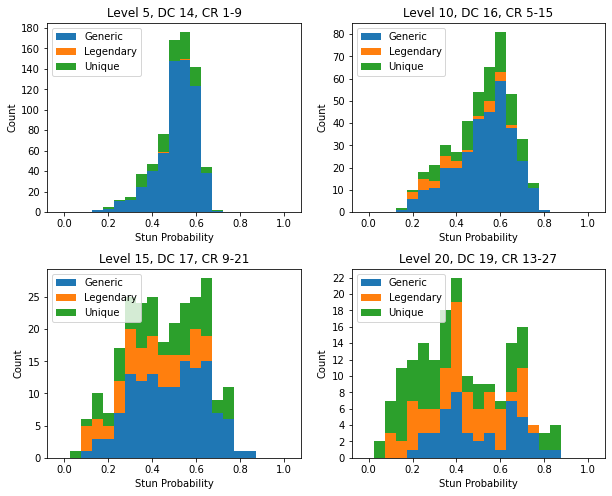

In [8]:
# Stun chance with Stunning Strike
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [20, 10,  5,  2]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

rSub = 2; cSub = 2; iSub = 0
fig = plt.figure(figsize=[5*cSub,4*rSub])
fig.subplots_adjust(hspace=0.3)

for level, CRdelta in zip(levels, CRdeltas):
    iSub = iSub + 1
    
    df1 = df0[df0['CR'].between(level-CRdelta, level+CRdelta)]
    df1['Hit Prob']  = 0.05*(20 + dfMonk.at[level-1, 'Attack Bonus'] - df0['AC'])
    df1.loc[df1['Hit Prob'] >= 1.0, 'Hit Prob'] = 0.95
    df1.loc[df1['Hit Prob'] <= 0.0, 'Hit Prob'] = 0.05
    df1['Stun Prob'] = 0.05*(dfMonk.at[level-1, 'Ki Save DC'] - df1['Con Save'] - 1)
    df1.loc[df1['Stun Prob'] > 1.0, 'Stun Prob'] = 1.00
    df1.loc[df1['Stun Prob'] < 0.0, 'Stun Prob'] = 0.00

    ax = plt.subplot(rSub, cSub, iSub, xlabel='Stun Probability', ylabel='Count', 
        title="Level {}, DC {}, CR {}-{}".format(level, dfMonk.at[level-1, 'Ki Save DC'], level-CRdelta, level+CRdelta))
    ax.hist((df1[df1['Category'].isin(['generic'])]['Stun Prob'], 
             df1[df1['Category'].isin(['legendary'])]['Stun Prob'], 
             df1[df1['Category'].isin(['unique'])]['Stun Prob']),
        rRange, density=False, histtype='bar', stacked=True, label=['Generic','Legendary','Unique'])
    ax.legend(loc='upper left')
    ax.yaxis.set_major_locator(MultipleLocator(majorLocs[iSub-1]))

    dfM = df1.groupby('Category').mean()['Stun Prob']
    dfS = df1.groupby('Category').std()['Stun Prob']
    print('Level {:2d}, Stun Probability: [{:.2f} ({:.2f}), {:.2f} ({:.2f}), {:.2f} ({:.2f})]'.format(level, 
        dfM['generic'], dfS['generic'],
        dfM['legendary'], dfS['legendary'],
        dfM['unique'], dfS['unique']))

plt.savefig('stun-probability-distribution-categories.png', dpi=300)

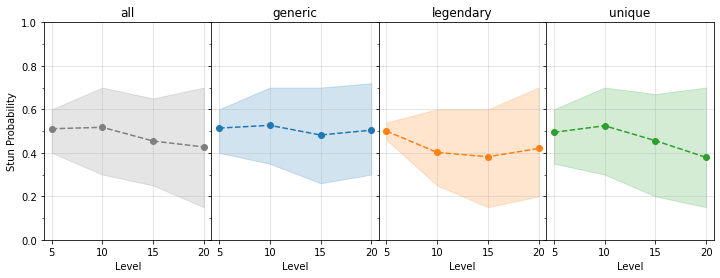

In [9]:
# Probability of landing a Stunning Strike
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

q1=0.10; q2=0.90
rSub = 1; cSub = 4; iSub = 0
fig = plt.figure(figsize=[3*cSub,4*rSub])
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ['#7f7f7f','#1f77b4','#ff7f0e','#2ca02c']

for cat, ax, c in zip(['all','generic','legendary','unique'], axs, colors):
    yMean = []; yStd  = []; yMin = []; yMax = []
    for level, CRdelta in zip(levels, CRdeltas):
        df1 = df0[df0['CR'].between(level-CRdelta, level+CRdelta)]
        df1['Hit Prob']  = 0.05*(20 + dfMonk.at[level-1, 'Attack Bonus'] - df0['AC'])
        df1.loc[df1['Hit Prob'] >= 1.0, 'Hit Prob'] = 0.95
        df1.loc[df1['Hit Prob'] <= 0.0, 'Hit Prob'] = 0.05
        df1['Stun Prob'] = 0.05*(dfMonk.at[level-1, 'Ki Save DC'] - df1['Con Save'] - 1)
        df1.loc[df1['Stun Prob'] > 1.0, 'Stun Prob'] = 1.00
        df1.loc[df1['Stun Prob'] < 0.0, 'Stun Prob'] = 0.00
        df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']

        if cat == 'all':
            dfC = df1['Stun Prob']
        else:
            dfC = df1[df1['Category'].isin([cat])]['Stun Prob']
        
        yMin.append(dfC.quantile(q1))
        yMax.append(dfC.quantile(q2))
        yMean.append(dfC.mean())

    ax.fill_between(levels, yMin, yMax, alpha=0.2, color=c)
    ax.plot(levels, yMean, 'o--', color=c)
    ax.set_title(cat)

for ax in axs.flat:
    ax.set(xlabel='Level', ylabel='Stun Probability', ylim=[0,1])
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.grid(which='major', axis='both', alpha=0.4)
    ax.label_outer()

plt.savefig('stun-probability-inner-quantile80-categories.png', dpi=300)

Level  5, Hit Probability: [0.63 (0.12), 0.60 (0.00), 0.64 (0.13)]
Level 10, Hit Probability: [0.61 (0.11), 0.55 (0.12), 0.65 (0.14)]
Level 15, Hit Probability: [0.65 (0.10), 0.60 (0.11), 0.66 (0.13)]
Level 20, Hit Probability: [0.65 (0.09), 0.62 (0.12), 0.61 (0.12)]


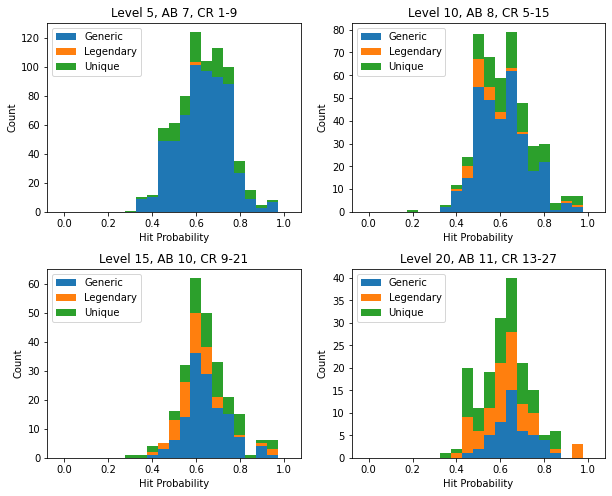

In [10]:
# Attack hit chance
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [20, 10, 10,  5]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

rSub = 2; cSub = 2; iSub = 0
fig = plt.figure(figsize=[5*cSub,4*rSub])
fig.subplots_adjust(hspace=0.3)

for level, CRdelta in zip(levels, CRdeltas):
    iSub = iSub + 1

    df1 = df0[df0['CR'].between(level-CRdelta, level+CRdelta)]
    df1['Hit Prob']  = 0.05*(20 + dfMonk.at[level-1, 'Attack Bonus'] - df0['AC'])
    df1.loc[df1['Hit Prob'] >= 1.0, 'Hit Prob'] = 0.95
    df1.loc[df1['Hit Prob'] <= 0.0, 'Hit Prob'] = 0.05
    df1['Stun Prob'] = 0.05*(dfMonk.at[level-1, 'Ki Save DC'] - df1['Con Save'] - 1)
    df1.loc[df1['Stun Prob'] > 1.0, 'Stun Prob'] = 1.00
    df1.loc[df1['Stun Prob'] < 0.0, 'Stun Prob'] = 0.00

    ax = plt.subplot(rSub, cSub, iSub, xlabel='Hit Probability', ylabel='Count', 
        title="Level {}, AB {}, CR {}-{}".format(level, dfMonk.at[level-1, 'Attack Bonus'], level-CRdelta, level+CRdelta))
    ax.hist((df1[df1['Category'].isin(['generic'])]['Hit Prob'], 
             df1[df1['Category'].isin(['legendary'])]['Hit Prob'], 
             df1[df1['Category'].isin(['unique'])]['Hit Prob']),
        rRange, density=False, histtype='bar', stacked=True, label=['Generic','Legendary','Unique'])
    ax.legend(loc='upper left')
    ax.yaxis.set_major_locator(MultipleLocator(majorLocs[iSub-1]))

    dfM = df1.groupby('Category').mean()['Hit Prob']
    dfS = df1.groupby('Category').std()['Hit Prob']
    print('Level {:2d}, Hit Probability: [{:.2f} ({:.2f}), {:.2f} ({:.2f}), {:.2f} ({:.2f})]'.format(level, 
        dfM['generic'], dfS['generic'],
        dfM['legendary'], dfS['legendary'],
        dfM['unique'], dfS['unique']))

plt.savefig('attack-hit-probability-distribution-categories.png', dpi=300)

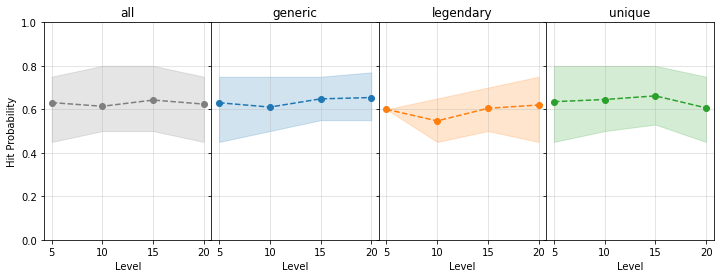

In [13]:
# Attacks hit chance
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

q1=0.10; q2=0.90
rSub = 1; cSub = 4; iSub = 0
fig = plt.figure(figsize=[3*cSub,4*rSub])
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ['#7f7f7f','#1f77b4','#ff7f0e','#2ca02c']

for cat, ax, c in zip(['all','generic','legendary','unique'], axs, colors):
    yMean = []; yStd  = []; yMin = []; yMax = []
    for level, CRdelta in zip(levels, CRdeltas):
        df1 = df0[df0['CR'].between(level-CRdelta, level+CRdelta)]
        df1['Stun Prob'] = 0.05*(dfMonk.at[level-1, 'Ki Save DC'] - df1['Con Save'] - 1)
        df1.loc[df1['Stun Prob'] > 1.0, 'Stun Prob'] = 1.00
        df1.loc[df1['Stun Prob'] < 0.0, 'Stun Prob'] = 0.00
        df1['Ki per Stun'] = 1.0/df1['Stun Prob']
        df1['Hit Prob']  = 0.05*(20 + dfMonk.at[level-1, 'Attack Bonus'] - df0['AC'])
        df1.loc[df1['Hit Prob'] >= 1.0, 'Hit Prob'] = 0.95
        df1.loc[df1['Hit Prob'] <= 0.0, 'Hit Prob'] = 0.05
        df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']
        df1['Attacks per Stun'] = 1.0/df1['Attack Stun Prob']

        if cat == 'all':
            dfC = df1['Hit Prob']
        else:
            dfC = df1[df1['Category'].isin([cat])]['Hit Prob']
        
        yMin.append(dfC.quantile(q1))
        yMax.append(dfC.quantile(q2))
        yMean.append(dfC.mean())

    ax.fill_between(levels, yMin, yMax, alpha=0.2, color=c)
    ax.plot(levels, yMean, 'o--', color=c)
    ax.set_title(cat)

for ax in axs.flat:
    ax.set(xlabel='Level', ylabel='Hit Probability', ylim=[0,1])
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    #ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.grid(which='major', axis='both', alpha=0.4)
    ax.label_outer()

plt.savefig('attack-hit-probability-inner-quantile80-categories.png', dpi=300)

Level  5, Attack Stun Probability: [0.33 (0.09), 0.30 (0.04), 0.32 (0.10)]
Level 10, Attack Stun Probability: [0.33 (0.12), 0.22 (0.09), 0.34 (0.13)]
Level 15, Attack Stun Probability: [0.32 (0.13), 0.23 (0.11), 0.31 (0.15)]
Level 20, Attack Stun Probability: [0.33 (0.12), 0.27 (0.13), 0.23 (0.16)]


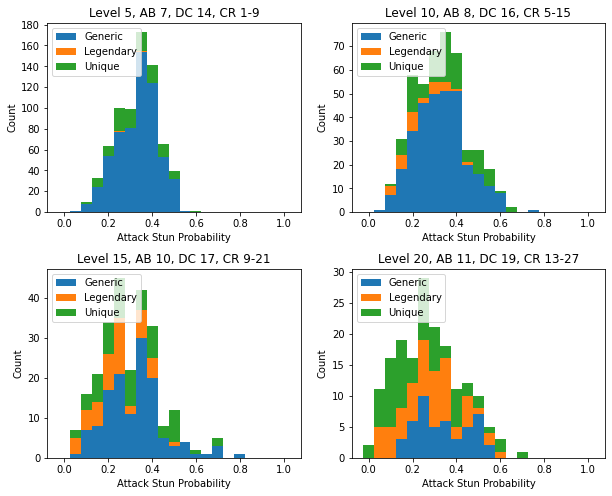

In [14]:
# Attack stun chance
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [20, 10, 10,  5]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

rSub = 2; cSub = 2; iSub = 0
fig = plt.figure(figsize=[5*cSub,4*rSub])
fig.subplots_adjust(hspace=0.3)

for level, CRdelta in zip(levels, CRdeltas):
    iSub = iSub + 1

    df1 = df0[df0['CR'].between(level-CRdelta, level+CRdelta)]
    df1['Hit Prob']  = 0.05*(20 + dfMonk.at[level-1, 'Attack Bonus'] - df0['AC'])
    df1.loc[df1['Hit Prob'] >= 1.0, 'Hit Prob'] = 0.95
    df1.loc[df1['Hit Prob'] <= 0.0, 'Hit Prob'] = 0.05
    df1['Stun Prob'] = 0.05*(dfMonk.at[level-1, 'Ki Save DC'] - df1['Con Save'] - 1)
    df1.loc[df1['Stun Prob'] > 1.0, 'Stun Prob'] = 1.00
    df1.loc[df1['Stun Prob'] < 0.0, 'Stun Prob'] = 0.00
    df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']

    ax = plt.subplot(rSub, cSub, iSub, xlabel='Attack Stun Probability', ylabel='Count', 
        title="Level {}, AB {}, DC {}, CR {}-{}".format(level, dfMonk.at[level-1, 'Attack Bonus'], 
        dfMonk.at[level-1, 'Ki Save DC'], level-CRdelta, level+CRdelta))
        
    ax.hist((df1[df1['Category'].isin(['generic'])]['Attack Stun Prob'], 
             df1[df1['Category'].isin(['legendary'])]['Attack Stun Prob'], 
             df1[df1['Category'].isin(['unique'])]['Attack Stun Prob']),
        rRange, density=False, histtype='bar', stacked=True, label=['Generic','Legendary','Unique'])
    ax.legend(loc='upper left')
    ax.yaxis.set_major_locator(MultipleLocator(majorLocs[iSub-1]))

    dfM = df1.groupby('Category').mean()['Attack Stun Prob']
    dfS = df1.groupby('Category').std()['Attack Stun Prob']
    print('Level {:2d}, Attack Stun Probability: [{:.2f} ({:.2f}), {:.2f} ({:.2f}), {:.2f} ({:.2f})]'.format(level, 
        dfM['generic'], dfS['generic'],
        dfM['legendary'], dfS['legendary'],
        dfM['unique'], dfS['unique']))

plt.savefig('attack-stun-probability-distribution-categories.png')

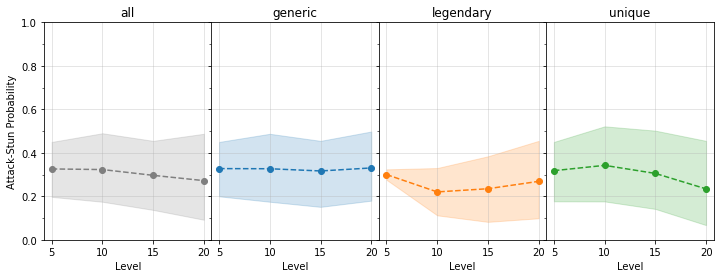

In [17]:
# Probability of hitting with an attack and landing a Stunning Strike
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

q1=0.10; q2=0.90
rSub = 1; cSub = 4; iSub = 0
fig = plt.figure(figsize=[3*cSub,4*rSub])
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ['#7f7f7f','#1f77b4','#ff7f0e','#2ca02c']

for cat, ax, c in zip(['all','generic','legendary','unique'], axs, colors):
    yMean = []; yStd  = []; yMin = []; yMax = []
    for level, CRdelta in zip(levels, CRdeltas):
        df1 = df0[df0['CR'].between(level-CRdelta, level+CRdelta)]
        df1['Hit Prob']  = 0.05*(20 + dfMonk.at[level-1, 'Attack Bonus'] - df0['AC'])
        df1.loc[df1['Hit Prob'] >= 1.0, 'Hit Prob'] = 0.95
        df1.loc[df1['Hit Prob'] <= 0.0, 'Hit Prob'] = 0.05
        df1['Stun Prob'] = 0.05*(dfMonk.at[level-1, 'Ki Save DC'] - df1['Con Save'] - 1)
        df1.loc[df1['Stun Prob'] > 1.0, 'Stun Prob'] = 1.00
        df1.loc[df1['Stun Prob'] < 0.0, 'Stun Prob'] = 0.00
        df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']

        if cat == 'all':
            dfC = df1['Attack Stun Prob']
        else:
            dfC = df1[df1['Category'].isin([cat])]['Attack Stun Prob']
        
        yMin.append(dfC.quantile(q1))
        yMax.append(dfC.quantile(q2))
        yMean.append(dfC.mean())

    ax.fill_between(levels, yMin, yMax, alpha=0.2, color=c)
    ax.plot(levels, yMean, 'o--', color=c)
    ax.set_title(cat)

for ax in axs.flat:
    ax.set(xlabel='Level', ylabel='Attack-Stun Probability', ylim=[0,1.0])
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.grid(which='major', axis='both', alpha=0.4)
    ax.label_outer()

plt.savefig('attack-stun-probability-inner-quantile80-categories.png', dpi=300)

Level  5, Ki per Stun: [1.82 (0.56), 2.02 (0.29), 2.00 (0.61)]
Level 10, Ki per Stun: [1.82 (0.77), 2.86 (1.08), 1.82 (0.82)]
Level 15, Ki per Stun: [2.00 (1.25), 2.50 (2.28), 2.00 (2.67)]
Level 20, Ki per Stun: [2.22 (0.88), 2.50 (2.04), 3.33 (3.65)]


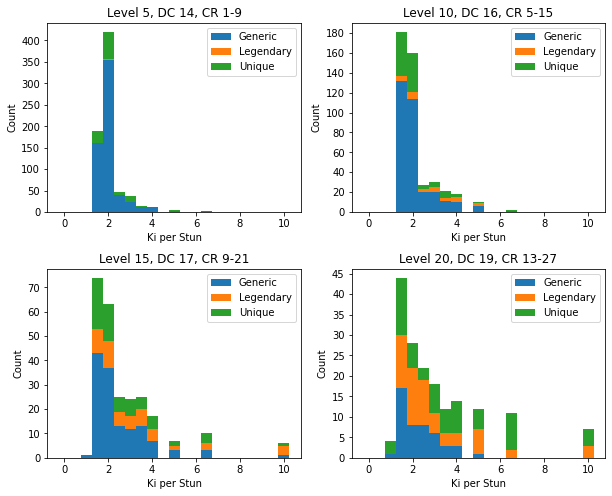

In [18]:
# Ki per Stun chance
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [50, 20, 10,  5]

rMin = 0; rMax = 10; rDel = 0.5
rLims = [rMin - rDel/2, rMax + rDel/2]
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

rSub = 2; cSub = 2; iSub = 0
fig = plt.figure(figsize=[5*cSub,4*rSub])
fig.subplots_adjust(hspace=0.3)

for level, CRdelta in zip(levels, CRdeltas):
    iSub = iSub + 1

    df1 = df0[df0['CR'].between(level-CRdelta, level+CRdelta)]
    df1['Hit Prob']  = 0.05*(20 + dfMonk.at[level-1, 'Attack Bonus'] - df0['AC'])
    df1.loc[df1['Hit Prob'] >= 1.0, 'Hit Prob'] = 0.95
    df1.loc[df1['Hit Prob'] <= 0.0, 'Hit Prob'] = 0.05
    df1['Stun Prob'] = 0.05*(dfMonk.at[level-1, 'Ki Save DC'] - df1['Con Save'] - 1)
    df1.loc[df1['Stun Prob'] > 1.0, 'Stun Prob'] = 1.00
    df1.loc[df1['Stun Prob'] < 0.0, 'Stun Prob'] = 0.00
    df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']
    df1['Ki per Stun'] = 1.0/df1['Stun Prob']
    df1['Attacks per Stun'] = 1.0/df1['Attack Stun Prob']

    ax = plt.subplot(rSub, cSub, iSub, xlabel='Ki per Stun', ylabel='Count', 
        title="Level {}, DC {}, CR {}-{}".format(level, dfMonk.at[level-1, 'Ki Save DC'], level-CRdelta, level+CRdelta))
    ax.hist((df1[df1['Category'].isin(['generic'])]['Ki per Stun'], 
             df1[df1['Category'].isin(['legendary'])]['Ki per Stun'], 
             df1[df1['Category'].isin(['unique'])]['Ki per Stun']),
        rRange, density=False, histtype='bar', stacked=True, label=['Generic','Legendary','Unique'])
    ax.legend(loc='upper right')
    ax.yaxis.set_major_locator(MultipleLocator(majorLocs[iSub-1]))

    dfM = df1.groupby('Category').median()['Ki per Stun']
    dfS = df1.groupby('Category').std()['Ki per Stun']
    print('Level {:2d}, Ki per Stun: [{:.2f} ({:.2f}), {:.2f} ({:.2f}), {:.2f} ({:.2f})]'.format(level, 
        dfM['generic'], dfS['generic'],
        dfM['legendary'], dfS['legendary'],
        dfM['unique'], dfS['unique']))

plt.savefig('ki-per-stun-probability-distribution-categories.png', dpi=300)

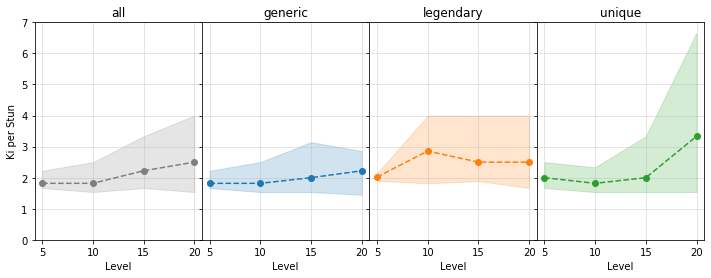

In [19]:
# ki per stun
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

q1=0.20; q2=0.80
rSub = 1; cSub = 4; iSub = 0
fig = plt.figure(figsize=[3*cSub,4*rSub])
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ['#7f7f7f','#1f77b4','#ff7f0e','#2ca02c']

for cat, ax, c in zip(['all','generic','legendary','unique'], axs, colors):
    yMean = []; yStd  = []; yMin = []; yMax = []
    for level, CRdelta in zip(levels, CRdeltas):
        df1 = df0[df0['CR'].between(level-CRdelta, level+CRdelta)]
        df1['Stun Prob'] = 0.05*(dfMonk.at[level-1, 'Ki Save DC'] - df1['Con Save'] - 1)
        df1.loc[df1['Stun Prob'] > 1.0, 'Stun Prob'] = 1.00
        df1.loc[df1['Stun Prob'] < 0.0, 'Stun Prob'] = 0.00
        df1['Ki per Stun'] = 1.0/df1['Stun Prob']
        df1['Hit Prob']  = 0.05*(20 + dfMonk.at[level-1, 'Attack Bonus'] - df0['AC'])
        df1.loc[df1['Hit Prob'] >= 1.0, 'Hit Prob'] = 0.95
        df1.loc[df1['Hit Prob'] <= 0.0, 'Hit Prob'] = 0.05
        df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']
        df1['Attacks per Stun'] = 1.0/df1['Attack Stun Prob']

        if cat == 'all':
            dfC = df1['Ki per Stun']
        else:
            dfC = df1[df1['Category'].isin([cat])]['Ki per Stun']
        
        yMin.append(dfC.quantile(q1))
        yMax.append(dfC.quantile(q2))
        yMean.append(dfC.median())

    ax.fill_between(levels, yMin, yMax, alpha=0.2, color=c)
    ax.plot(levels, yMean, 'o--', color=c)
    ax.set_title(cat)

for ax in axs.flat:
    ax.set(xlabel='Level', ylabel='Ki per Stun', ylim=[0,7])
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    #ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.grid(which='major', axis='both', alpha=0.4)
    ax.label_outer()

plt.savefig('ki-per-stun-probability-inner-quantile60-categories.png', dpi=300)

Level  5, Attacks per Stun: [3.03 (1.41), 3.37 (0.48), 3.17 (1.49)]
Level 10, Attacks per Stun: [3.08 (1.71), 5.19 (2.31), 3.03 (1.60)]
Level 15, Attacks per Stun: [3.08 (2.18), 4.21 (5.09), 3.57 (5.22)]
Level 20, Attacks per Stun: [3.33 (1.44), 3.71 (4.81), 4.71 (8.01)]


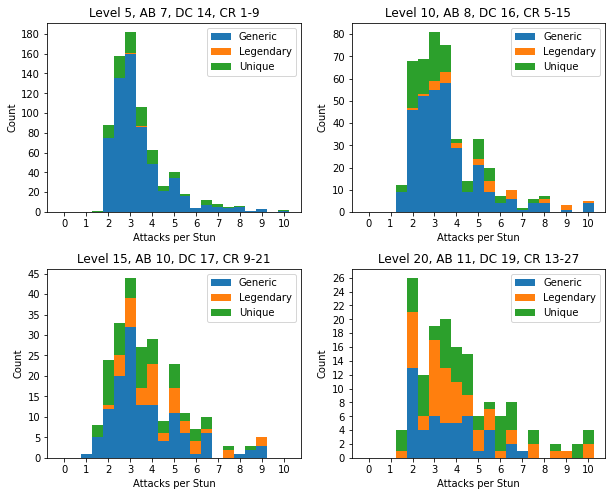

In [20]:
# Attack stun chance
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [20, 10,  5,  2]

rMin = 0; rMax = 10; rDel = 0.5
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

rSub = 2; cSub = 2; iSub = 0
fig = plt.figure(figsize=[5*cSub,4*rSub])
fig.subplots_adjust(hspace=0.3)

for level, CRdelta in zip(levels, CRdeltas):
    iSub = iSub + 1

    df1 = df0[df0['CR'].between(level-CRdelta, level+CRdelta)]
    df1['Hit Prob']  = 0.05*(20 + dfMonk.at[level-1, 'Attack Bonus'] - df0['AC'])
    df1.loc[df1['Hit Prob'] >= 1.0, 'Hit Prob'] = 0.95
    df1.loc[df1['Hit Prob'] <= 0.0, 'Hit Prob'] = 0.05
    df1['Stun Prob'] = 0.05*(dfMonk.at[level-1, 'Ki Save DC'] - df1['Con Save'] - 1)
    df1.loc[df1['Stun Prob'] > 1.0, 'Stun Prob'] = 1.00
    df1.loc[df1['Stun Prob'] < 0.0, 'Stun Prob'] = 0.00
    df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']
    df1['Ki per Stun'] = 1.0/df1['Stun Prob']
    df1['Attacks per Stun'] = 1.0/df1['Attack Stun Prob']

    ax = plt.subplot(rSub, cSub, iSub, xlabel='Attacks per Stun', ylabel='Count', 
        title="Level {}, AB {}, DC {}, CR {}-{}".format(level, dfMonk.at[level-1, 'Attack Bonus'], 
        dfMonk.at[level-1, 'Ki Save DC'], level-CRdelta, level+CRdelta))
    ax.hist((df1[df1['Category'].isin(['generic'])]['Attacks per Stun'], 
             df1[df1['Category'].isin(['legendary'])]['Attacks per Stun'], 
             df1[df1['Category'].isin(['unique'])]['Attacks per Stun']),
        rRange, density=False, histtype='bar', stacked=True, label=['Generic','Legendary','Unique'])
    ax.legend(loc='upper right')
    ax.yaxis.set_major_locator(MultipleLocator(majorLocs[iSub-1]))
    ax.xaxis.set_major_locator(MultipleLocator(1))

    dfM = df1.groupby('Category').median()['Attacks per Stun']
    dfS = df1.groupby('Category').std()['Attacks per Stun']
    print('Level {:2d}, Attacks per Stun: [{:.2f} ({:.2f}), {:.2f} ({:.2f}), {:.2f} ({:.2f})]'.format(level, 
        dfM['generic'], dfS['generic'],
        dfM['legendary'], dfS['legendary'],
        dfM['unique'], dfS['unique']))

plt.savefig('attacks-per-stun-probability-distribution-categories.png', dpi=300)

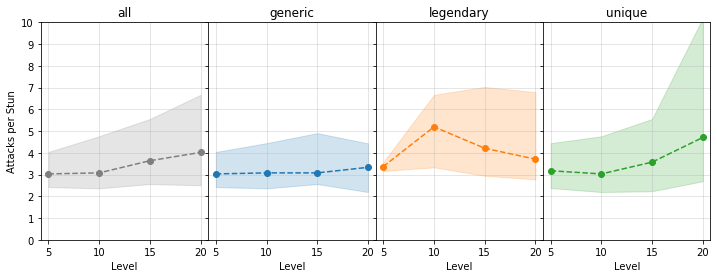

In [21]:
# Attacks per stun
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

q1=0.20; q2=0.80
rSub = 1; cSub = 4; iSub = 0
fig = plt.figure(figsize=[3*cSub,4*rSub])
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ['#7f7f7f','#1f77b4','#ff7f0e','#2ca02c']

for cat, ax, c in zip(['all','generic','legendary','unique'], axs, colors):
    yMean = []; yStd  = []; yMin = []; yMax = []
    for level, CRdelta in zip(levels, CRdeltas):
        df1 = df0[df0['CR'].between(level-CRdelta, level+CRdelta)]
        df1['Stun Prob'] = 0.05*(dfMonk.at[level-1, 'Ki Save DC'] - df1['Con Save'] - 1)
        df1.loc[df1['Stun Prob'] > 1.0, 'Stun Prob'] = 1.00
        df1.loc[df1['Stun Prob'] < 0.0, 'Stun Prob'] = 0.00
        df1['Ki per Stun'] = 1.0/df1['Stun Prob']
        df1['Hit Prob']  = 0.05*(20 + dfMonk.at[level-1, 'Attack Bonus'] - df0['AC'])
        df1.loc[df1['Hit Prob'] >= 1.0, 'Hit Prob'] = 0.95
        df1.loc[df1['Hit Prob'] <= 0.0, 'Hit Prob'] = 0.05
        df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']
        df1['Attacks per Stun'] = 1.0/df1['Attack Stun Prob']

        if cat == 'all':
            dfC = df1['Attacks per Stun']
        else:
            dfC = df1[df1['Category'].isin([cat])]['Attacks per Stun']
        
        yMin.append(dfC.quantile(q1))
        yMax.append(dfC.quantile(q2))
        yMean.append(dfC.median())

    ax.fill_between(levels, yMin, yMax, alpha=0.2, color=c)
    ax.plot(levels, yMean, 'o--', color=c)
    ax.set_title(cat)

for ax in axs.flat:
    ax.set(xlabel='Level', ylabel='Attacks per Stun', ylim=[0,10])
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    #ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.grid(which='major', axis='both', alpha=0.4)
    ax.label_outer()

plt.savefig('attacks-per-stun-inner-quantile60-categories.png', dpi=300)

Level  5, Stun Probability: [0.36 (0.08), 0.54 (0.07)]
Level 10, Stun Probability: [0.36 (0.09), 0.60 (0.08)]
Level 15, Stun Probability: [0.33 (0.11), 0.61 (0.09)]
Level 20, Stun Probability: [0.31 (0.13), 0.65 (0.11)]


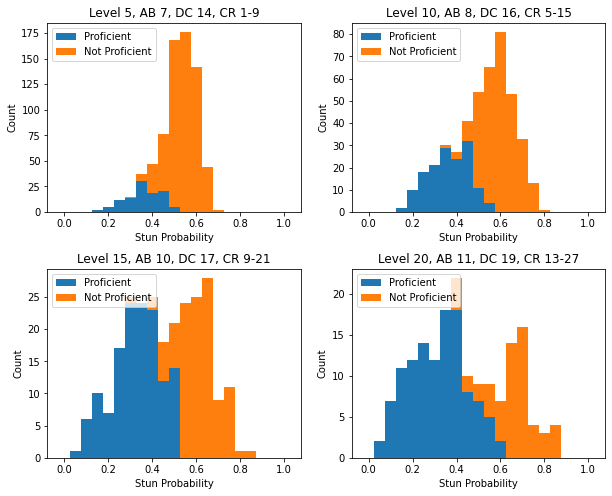

In [6]:
# stun probability grouped
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [20, 10, 10,  5]

rMin = 0; rMax = 1; rDel = 0.05
rLims = [rMin - rDel/2, rMax + rDel/2]
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

rSub = 2; cSub = 2; iSub = 0
fig = plt.figure(figsize=[5*cSub,4*rSub])
fig.subplots_adjust(hspace=0.3)

for level, CRdelta in zip(levels, CRdeltas):
    iSub = iSub + 1

    df1 = df0[df0['CR'].between(level-CRdelta, level+CRdelta)]
    df1['Hit Prob']  = 0.05*(20 + dfMonk.at[level-1, 'Attack Bonus'] - df0['AC'])
    df1.loc[df1['Hit Prob'] >= 1.0, 'Hit Prob'] = 0.95
    df1.loc[df1['Hit Prob'] <= 0.0, 'Hit Prob'] = 0.05
    df1['Stun Prob'] = 0.05*(dfMonk.at[level-1, 'Ki Save DC'] - df1['Con Save'] - 1)
    df1.loc[df1['Stun Prob'] > 1.0, 'Stun Prob'] = 1.00
    df1.loc[df1['Stun Prob'] < 0.0, 'Stun Prob'] = 0.00
    df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']

    ax = plt.subplot(rSub, cSub, iSub, xlabel='Stun Probability', ylabel='Count', 
        title="Level {}, AB {}, DC {}, CR {}-{}".format(level, dfMonk.at[level-1, 'Attack Bonus'], 
        dfMonk.at[level-1, 'Ki Save DC'], level-CRdelta, level+CRdelta))
    ax.hist((df1[df1['Con Prof'].isin([True])]['Stun Prob'], 
             df1[df1['Con Prof'].isin([False])]['Stun Prob']),
        rRange, density=False, histtype='bar', stacked=True, label=['Proficient','Not Proficient'])
    ax.legend(loc='upper left')
    #ax.yaxis.set_major_locator(MultipleLocator(majorLocs[iSub-1]))

    dfP = df1[df1['Con Prof'].isin([True])]['Stun Prob']
    dfN = df1[df1['Con Prof'].isin([False])]['Stun Prob']
    print('Level {:2d}, Stun Probability: [{:.2f} ({:.2f}), {:.2f} ({:.2f})]'.format(level, 
        dfP.mean(), dfP.std(),
        dfN.mean(), dfN.std()))

plt.savefig('stun-probability-distribution-proficient.png', dpi=300)

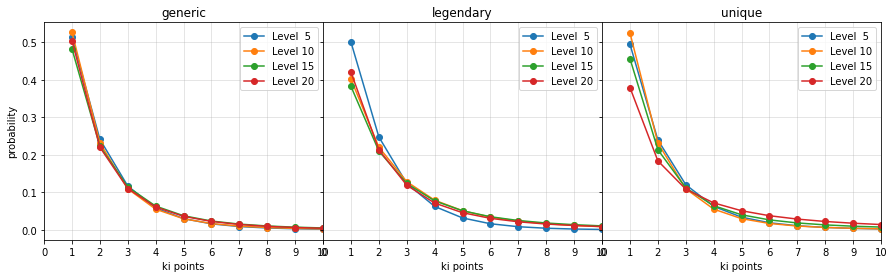

In [24]:
# Attack-Stun probability range
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [20, 10,  2,  2]

attempts = range(1,30)

rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

rSub = 1; cSub = 3; iSub = 0
fig = plt.figure(figsize=[5*cSub,4*rSub])
gs = fig.add_gridspec(rSub, cSub, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for cat, ax in zip(['generic','legendary','unique'], axs):
    ax.set(title=cat, ylabel='probability', xlabel='ki points')
    kMean = []
    for level, CRdelta in zip(levels, CRdeltas):
        df1 = df0[df0['CR'].between(level-CRdelta, level+CRdelta)]
        df1['Stun Prob'] = 0.05*(dfMonk.at[level-1, 'Ki Save DC'] - df1['Con Save'] - 1)
        df1.loc[df1['Stun Prob'] > 1.0, 'Stun Prob'] = 1.00
        df1.loc[df1['Stun Prob'] < 0.0, 'Stun Prob'] = 0.00
        df1['Ki per Stun'] = 1.0/df1['Stun Prob']

        df1['Hit Prob']  = 0.05*(20 + dfMonk.at[level-1, 'Attack Bonus'] - df0['AC'])
        df1.loc[df1['Hit Prob'] >= 1.0, 'Hit Prob'] = 0.95
        df1.loc[df1['Hit Prob'] <= 0.0, 'Hit Prob'] = 0.05
        df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']
        df1['Attacks per Stun'] = 1.0/df1['Attack Stun Prob']

        dfC = df1[df1['Category'].isin([cat])]
        yMean = []
        for att in attempts:
            yMean.append(np.mean(dfC['Stun Prob']*np.power(1 - dfC['Stun Prob'], att-1)))

        ax.plot(attempts, yMean, 'o-', label='Level {:2d}'.format(level))
        kMean.append(np.dot(yMean, attempts))

    #print('{} - Level {:2d}: ['.format(cat, level), ', '.join('{:.2f}'.format(k) for k in kMean), '] ki per stun')

for ax in axs.flat:
    ax.legend()
    ax.set(xlim=[0,10])
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.grid(which='major', axis='both', alpha=0.4)
    ax.label_outer()

#plt.savefig('stun-per-ki-probability-distribution.png', dpi=300)

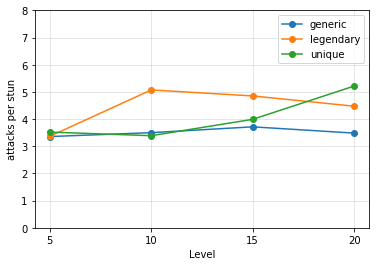

In [23]:
# Attack-Stun probability range
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRdeltas  = [ 4,  5,  6,  7]
levels    = [ 5, 10, 15, 20]
majorLocs = [20, 10,  2,  2]

attempts = range(1,30)

col = 'Attack Stun Prob'
rMin = 0; rMax = 1; rDel = 0.05
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure()
ax = plt.axes(xlabel='Level', ylabel='attacks per stun', ylim=[0,8])

for cat in ['generic','legendary','unique']:
    kMean = []
    for level, CRdelta in zip(levels, CRdeltas):
        df1 = df0[df0['CR'].between(level-CRdelta, level+CRdelta)]
        df1['Stun Prob'] = 0.05*(dfMonk.at[level-1, 'Ki Save DC'] - df1['Con Save'] - 1)
        df1.loc[df1['Stun Prob'] > 1.0, 'Stun Prob'] = 1.00
        df1.loc[df1['Stun Prob'] < 0.0, 'Stun Prob'] = 0.00
        df1['Ki per Stun'] = 1.0/df1['Stun Prob']

        df1['Hit Prob']  = 0.05*(20 + dfMonk.at[level-1, 'Attack Bonus'] - df0['AC'])
        df1.loc[df1['Hit Prob'] >= 1.0, 'Hit Prob'] = 0.95
        df1.loc[df1['Hit Prob'] <= 0.0, 'Hit Prob'] = 0.05
        df1['Attack Stun Prob'] = df1['Hit Prob']*df1['Stun Prob']
        df1['Attacks per Stun'] = 1.0/df1['Attack Stun Prob']

        dfC = df1[df1['Category'].isin([cat])]
        yMean = []
        for att in attempts:
            yMean.append(np.mean(dfC[col]*np.power(1 - dfC[col], att-1)))

        kMean.append(np.dot(yMean, attempts))

    ax.plot(levels, kMean, 'o-', label=cat)

ax.legend()
ax.grid(which='major', axis='both', alpha=0.4)
ax.xaxis.set_major_locator(MultipleLocator(5))

#plt.savefig('attacks-per-stun-mean.png', dpi=300)